# Analyze colocalization of genomic features
Limitations: When the window is a lot larger than the feature (especially if the feature is sparse), it takes into account large flanking regions. Therefore this gives us information about general characteristics of the genomic region where the feature is abundant. Also when comparing abundant feature with a sparse one (for example the sparse one always appears near abundant one, but there are lot of instances where the abundant one is not near the sparse one), the correlation coefficient value will be less extreme even though there is a relationship.

Metric used: Proportion of bases in window overlapping feature.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mcolors
from te_module.classes.bed import Bed
from te_module.classes.gff import Gff


## Prepare bigwigs

In [9]:
window_size = 100_000
source_assembly = 'Lsyl'
fasta_file = 'data/assembly/' + source_assembly + '.fasta'
chr_sizes = 'data/chr_sizes/' + source_assembly + '_chr_sizes.tsv'
output_prefix = 'data/colocalization/bigwigs/' + source_assembly + '_'
output_suffix = '_100kb_windows.bw'

In [10]:
feature_paths = {}
# strict - no merging
feature_paths['genes'] = 'data/genes/Luzula_sylvatica_genes.bed'
feature_paths['LTR-TEs'] = 'data/dante_ltr/Lsyl_dante_ltr.bed'
feature_paths['LINE'] = 'data/transposons/LINE.bed'
feature_paths['H3K4me3'] = 'data/chip-seq/consensus_peaks/H3K4_peaks.bed'
feature_paths['H3K9me2'] = 'data/chip-seq/consensus_peaks/H3K9_peaks.bed'
# merged - especially useful for distrupted arrays
feature_paths['lusy1'] = 'data/satellites/Lusy1_merged_15k.bed'
feature_paths['lusy2'] = 'data/satellites/Lusy2_merged_15k.bed'
feature_paths['centromere'] = 'data/chip-seq/consensus_peaks/CenH3_150k_merged_units.bed'
feature_paths['satellite-free_centromere'] = 'data/chip-seq/consensus_peaks/non_satellite_units.bed'
feature_paths['lusy1_functional'] = 'data/satellites/Lusy1_functional_fragments.bed'
feature_paths['lusy1_nonfunctional'] = 'data/satellites/Lusy1_nonfunctional_arrays.bed'
feature_paths['lusy2_functional'] = 'data/satellites/Lusy2_functional_fragments.bed'
feature_paths['lusy2_nonfunctional'] = 'data/satellites/Lusy2_nonfunctional_arrays.bed'
feature_paths['randomness'] = 'data/peaks/randomness.bed'


In [11]:
'''
BigWig files for genomic features
'''
bigwig_paths = {}
for feature_name in feature_paths:
    bed = Bed(feature_paths[feature_name])
    output_path = output_prefix + feature_name + output_suffix
    bed.bed_window_coverage_to_bigwig(window_size, chr_sizes, output_path)
    bigwig_paths[feature_name] = output_path

Bigwig file created: data/colocalization/bigwigs/Lsyl_genes_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_LTR-TEs_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_LINE_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_H3K4me3_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_H3K9me2_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_lusy1_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_lusy2_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_centromere_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_satellite-free_centromere_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_lusy1_functional_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_lusy1_nonfunctional_100kb_windows.bw
Bigwig file created: data/colocalization/bigwigs/Lsyl_lusy2_functional_100kb_windows.bw
Bigwig fil

In [12]:

'''
BigWig file for GC content
'''

bed = Bed()
output_path = output_prefix + 'gc_content' + output_suffix
bed.gc_content_in_windows(chr_sizes, output_path, fasta_file, window_size)
bigwig_paths['gc_content'] = output_path



Bigwig file created: data/colocalization/bigwigs/Lsyl_gc_content_100kb_windows.bw
hi


## Create a dataframe with feature values in each window

Create dataframe (wigs) for each feature and join them to a dataframe:

In [13]:
joined_df = pd.DataFrame()

for name, bigwig_path in bigwig_paths.items():
    command = f'bigWigToWig {bigwig_path} tmp/{name}.wig'
    os.system(command)
    # read wig file into dataframe
    colnames = ['chr', 'start', 'end', name]
    df = pd.read_csv('tmp/' + name + '.wig', sep='\t', header=None, comment='#', names=colnames)
    # add df to joined_df
    if joined_df.empty:
        joined_df = df
    else:
        joined_df = joined_df.merge(df, on=['chr', 'start', 'end'], how='outer')
    # remove tmp files
    os.system('rm tmp/' + name + '.wig')

joined_df = joined_df.fillna(0)

# get rid of window identifiers
relevant_df = joined_df.drop(columns=['chr', 'start', 'end'])

## Create correlogram

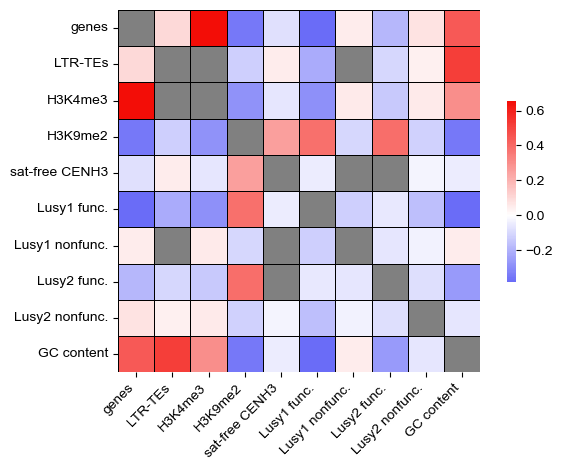

In [14]:

correlation_matrix = pd.DataFrame(index=relevant_df.columns, columns=relevant_df.columns)
p_value_matrix = pd.DataFrame(index=relevant_df.columns, columns=relevant_df.columns)
for feature1 in relevant_df.columns:
    for feature2 in relevant_df.columns:
        if feature1 != feature2:
            corr, p_value = spearmanr(relevant_df[feature1], relevant_df[feature2])
            correlation_matrix.loc[feature1, feature2] = corr
            p_value_matrix.loc[feature1, feature2] = p_value

subset = ['genes', 'LTR-TEs', 'H3K4me3', 'H3K9me2', 'satellite-free_centromere', 
                    'lusy1_functional', 'lusy1_nonfunctional', 'lusy2_functional', 'lusy2_nonfunctional', 'gc_content']
subset_df= correlation_matrix[subset].loc[subset]
subset_df = subset_df.astype(float)
p_value_subset_df = p_value_matrix[subset].loc[subset]
p_value_subset_df = p_value_subset_df.fillna(1)
p_value_subset_df = p_value_subset_df.astype(float)
p_values = p_value_subset_df.values.flatten()
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]
adjusted_p_values = adjusted_p_values.reshape(p_value_subset_df.shape)
p_values_adjusted_df = pd.DataFrame(adjusted_p_values, index=subset, columns=subset)


mask = p_values_adjusted_df > 0.05


short_labels = ['genes', 'LTR-TEs', 'H3K4me3', 'H3K9me2', 'sat-free CENH3', 
                    'Lusy1 func.', 'Lusy1 nonfunc.', 'Lusy2 func.', 'Lusy2 nonfunc.', 'GC content']


                
# correct p-values


# set the default font family to Arial
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

f, ax = plt.subplots()
colors = ['#0004f2ff', 'white','#f30600f8']
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
cmap.set_bad("grey")
sns.heatmap(subset_df, mask=mask, cmap=cmap, center=0, 
            square=True, linewidths=.5,linecolor='black', cbar_kws={"shrink": .5})
plt.xticks(np.arange(len(short_labels))+0.5, short_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(short_labels))+0.5, short_labels, rotation=0, va='center')
plt.tight_layout()
plt.savefig('data/figures/colocalization_heatmap.svg', dpi=300)
